In [2]:
#one way, between subject anovas (one dependent variable, independent categories)
#python was not made for stats, so its best to use R when running these tests
#but alas
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [3]:
apps= pd.read_csv('C:/Users/latri/Desktop/NEWgoogleplaystore.csv')
#want to know: Is there a difference in the number of reviews among the three app categories of beauty, food and drink, and photography? 
#x, independent variable is the three categories. categorical
#y dependent variable is the reviews. continuous
#will wrangle data so we can also test assumptions and run post hocs

In [4]:
#we will single out the categories we want by making a list, 
#using isin searches through the data and ONLY keeps what matches the list
#then youll want to apply it back the the true data and make a new data from "copied" from the main one, instead of being sliced out
categories = ['BEAUTY', 'FOOD_AND_DRINK','PHOTOGRAPHY']
#this seems to act kind of like a for loop
apps1 = apps['Category'].isin(categories)
#this makes it a data frame again (propabably and imprtant distinction for the computer)
apps2 = apps[apps1].copy()

In [14]:
#now we only want two variables for the test we are going to run
apps3 = apps2[['Category','Reviews']]
#and want to make sure our continuous variable (reviews) is an integer
apps3.info()
apps3.Reviews = apps3.Reviews.astype(int)
#have an error because this "data frame" is still a slice! (knew the computer cared)
#but it will still work
apps3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515 entries, 98 to 10740
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  515 non-null    object
 1   Reviews   515 non-null    object
dtypes: object(2)
memory usage: 12.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 515 entries, 98 to 10740
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  515 non-null    object
 1   Reviews   515 non-null    int32 
dtypes: int32(1), object(1)
memory usage: 10.1+ KB


D:\AnacondaDATASCI\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [6]:
#recode the data because post hocs and assumption testing doesnt take words
def recode (series):
    if series == "BEAUTY": 
        return 0
    if series == "FOOD_AND_DRINK": 
        return 1
    if series == "PHOTOGRAPHY": 
        return 2

apps3['CategoryR'] = apps3['Category'].apply(recode)

#then drop the old category column (new slice)
apps4 = apps3[['CategoryR','Reviews']]

<ipython-input-6-5b22d6d1c690>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apps3['CategoryR'] = apps3['Category'].apply(recode)


D:\AnacondaDATASCI\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


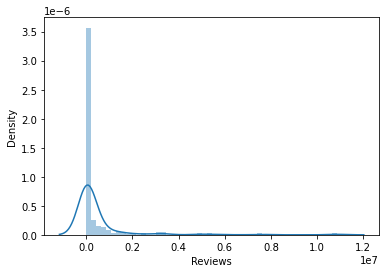

In [7]:
# test that the dependent variable (continuous) is normally distributed
sns.distplot(apps4['Reviews'])
#highly positively skewed! we will transform
apps4['ReviewsSQRT'] = np.sqrt(apps4['Reviews'])
#which makes it a bit better

In [8]:
#test for homogeneity of variance using Bartletts or Fligner, looking for non-significant results
#since this data is correct we would use bartletts, but will do both to learn them
scipy.stats.bartlett(apps4['ReviewsSQRT'], apps4['CategoryR'])
#p was significant, so we failed the test for homogeneity

#and fligners test
scipy.stats.fligner(apps4['ReviewsSQRT'], apps4['CategoryR'])
#also failed, so time to correct for the violation
#just kidding, pything cant do any of them! so there will be inaccuracies if we continue
#switch to R!

FlignerResult(statistic=642.0602581715318, pvalue=1.1908711834100128e-141)

In [10]:
#ANOVAs with equal variance, one way anovas: each IV crossed with the DV
stats.f_oneway(apps['Reviews'][apps['Cate
                                    ory']=='BEAUTY'],
                    apps['Reviews'][apps['Category']=='FOOD_AND_DRINK'],
                    apps['Reviews'][apps['Category']=='PHOTOGRAPHY'])
#p is significant meaning there is a significant difference in reviews for each category

F_onewayResult(statistic=11.467490725511773, pvalue=1.342932747373518e-05)

In [ ]:
#when the anova has unequal variance (no homogeneity) there is no way to compute them in python! switch to R

In [13]:
#post hocs help figure out what groups differ from each other. we will use Tukey because it automatically codes for post hocs
postHoc = MultiComparison(apps4['ReviewsSQRT'], apps4['CategoryR'])
postHocResults = postHoc.tukeyhsd()
print(postHocResults)
#tough cause we had to recode but recall: 0=beauty, 1=food/drink, 2=photog
#give us mean difference in the number of reviews per comparison, 
#plus the confidence intervaland if we can reject the null hypothesis
apps4.groupby('CategoryR').mean()

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     0      1   111.89 0.4078 -93.3166 317.0966  False
     0      2  419.474  0.001 233.9713 604.9768   True
     1      2  307.584  0.001  176.819 438.3491   True
------------------------------------------------------


,Reviews,ReviewsSQRT
CategoryR,,
0,7476.226415,48.854024
1,69947.480315,160.744038
2,637363.134328,468.328067
